Starting simulation of 10000 seasons...
Sim 1, Game 1: Team Strength=0.613, Opp Strength=0.621
Sim 1, Game 2: Team Strength=0.643, Opp Strength=0.649
Sim 1, Game 3: Team Strength=0.673, Opp Strength=0.284
Sim 1, Game 4: Team Strength=0.576, Opp Strength=0.833
Sim 1, Game 5: Team Strength=0.556, Opp Strength=0.468
Sim 1, Game 6: Team Strength=0.673, Opp Strength=0.229
Sim 1, Game 7: Team Strength=0.633, Opp Strength=0.498
Sim 1, Game 8: Team Strength=0.640, Opp Strength=0.448
Sim 1, Game 9: Team Strength=0.700, Opp Strength=0.845
Sim 1, Game 10: Team Strength=0.700, Opp Strength=0.769
Sim 1, Game 11: Team Strength=0.700, Opp Strength=0.590
Sim 1, Game 12: Team Strength=0.673, Opp Strength=0.504
Sim 1, Game 13: Team Strength=0.700, Opp Strength=0.283
Sim 1, Game 14: Team Strength=0.660, Opp Strength=0.584
Sim 1, Game 15: Team Strength=0.673, Opp Strength=0.625
Sim 1, Game 16: Team Strength=0.633, Opp Strength=0.514
Sim 1, Game 17: Team Strength=0.669, Opp Strength=0.493
Sim 1, Game 18: T

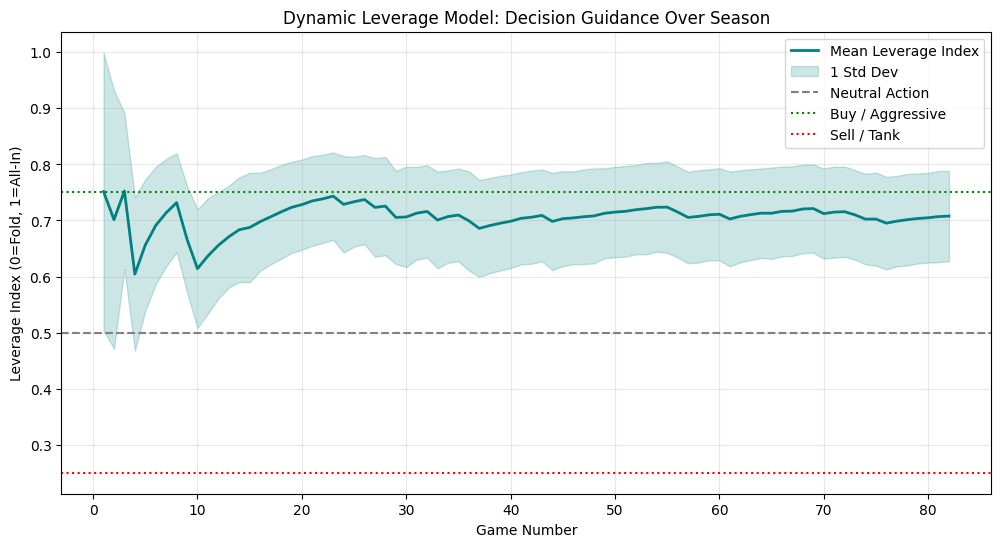

Avg Wins: 65.3
Avg Profit: $349.8M


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. CONFIGURATION & INITIALIZATION ---

# Simulation Parameters
NUM_SIMULATIONS = 10000
GAMES_IN_SEASON = 82
CURRENT_GAME_INDEX = 0  # Start from game 0

# Financial Constants (in Millions USD)
# Based on 2024-25 Data & Projections
FINANCIALS = {
    'team_valuation': 3800,
    'baseline_revenue': 328,
    'initial_debt': 304,
    'salary_cap': 166,
    'luxury_tax': 202,
    'operating_income': 81,
    'max_debt_capacity': 600,  # Limit set by league rules approx
    'safe_debt_threshold': 400 # ~5x operating income
}

# Roster Data: [Player Name, Skill (0-1), Injury Probability per Game]
# Skill: Based on PER/Impact. Injury Prob: Based on history (LaMelo/Mark Williams high)
ROSTER = [
    # Star: 20.6 PPG. High risk (missed ~35% of games)
    {'name': 'Brandon Miller',  'skill': 0.85, 'injury_prob': 0.35, 'star_power': True},
    
    # Star: 19.1 PPG + 7.6 AST. Mod risk (missed ~20% of games)
    {'name': 'LaMelo Ball',     'skill': 0.88, 'injury_prob': 0.20, 'star_power': True},
    
    # Core: 18.9 PPG. Very Durable (missed ~2% of games)
    {'name': 'Kon Knueppel',    'skill': 0.82, 'injury_prob': 0.02, 'star_power': True},
    
    # Core: 18.5 PPG. Very Durable (missed ~2% of games)
    {'name': 'Miles Bridges',   'skill': 0.80, 'injury_prob': 0.02, 'star_power': False},
    
    # 6th Man: 14.3 PPG. Mod risk (missed ~18% of games)
    {'name': 'Collin Sexton',   'skill': 0.70, 'injury_prob': 0.18, 'star_power': False},
    
    # Center: 8.6 PPG, 1.5 BLK. Mod risk (missed ~25% of games)
    {'name': 'Ryan Kalkbrenner','skill': 0.65, 'injury_prob': 0.24, 'star_power': False},
    
    # Role: 8.4 PPG, 8.4 REB. Durable (missed ~8% of games)
    {'name': 'Moussa Diabate',  'skill': 0.60, 'injury_prob': 0.08, 'star_power': False},
    
    # Bench Aggregation (Mann, Salaun, etc.)
    {'name': 'Replacement',     'skill': 0.40, 'injury_prob': 0.00, 'star_power': False} 
]

# Weights for Indices
WEIGHTS = {
    'perf_win_proj': 0.6,    # Alpha
    'perf_player': 0.4,      # Beta
    'lev_perf': 5.0,         # Weight of Performance on Leverage
    'lev_fin': 3.0,          # Weight of Finance on Leverage
    'lev_risk': -4.0,        # Negative weight of Risk on Leverage
    'revenue_win_factor': 0.5, # Revenue added per win (millions)
    'revenue_star_factor': 1.2 # Revenue added per game if Stars play (millions)
}

# --- 2. HELPER FUNCTIONS ---

def generate_schedule(num_games):
    """
    Creates a schedule of opponent strengths (0-1).
    Distributes Elite (>0.7), Avg (0.4-0.6), Weak (<0.3) teams.
    """
    # Standard NBA distribution approx
    opponents = []
    for _ in range(num_games):
        rand = np.random.random()
        if rand < 0.20: strength = np.random.uniform(0.70, 0.90) # Elite
        elif rand < 0.70: strength = np.random.uniform(0.40, 0.65) # Average
        else: strength = np.random.uniform(0.15, 0.35) # Tanking
        opponents.append(strength)
    return np.array(opponents)

def logistic_win_prob(team_talent, opp_talent):
    """Calculates win probability based on talent difference."""
    diff = team_talent - opp_talent
    # Logistic function parameters (calibrated for realistic NBA win rates)
    b0 = 0.0 # Neutral court assumption for simplicity average
    b0 = np.random.choice([0.0, .16])
    b1 = 6.0 # Slope - higher means talent diff matters more
    return 1 / (1 + np.exp(-(b0 + b1 * diff)))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# --- 3. MONTE CARLO SIMULATION CORE ---

print(f"Starting simulation of {NUM_SIMULATIONS} seasons...")

# Storage for results
all_sim_leverage = np.zeros((NUM_SIMULATIONS, GAMES_IN_SEASON))
all_sim_wins = np.zeros(NUM_SIMULATIONS)
all_sim_profit = np.zeros(NUM_SIMULATIONS)

# Generate one master schedule for consistency across runs (or randomize if desired)
schedule = generate_schedule(GAMES_IN_SEASON)

for sim in range(NUM_SIMULATIONS):
    
    # Reset Season State
    current_wins = 0
    current_revenue = FINANCIALS['baseline_revenue']
    current_debt = FINANCIALS['initial_debt']
    
    # Trackers for this season
    season_leverage = []
    
    # Active Roster Status (1 = Healthy, 0 = Injured)
    # Simple model: Check injury every game. If injured, out for 'd' games?
    # Simplified: Independent probability per game for availability
    
    for t in range(GAMES_IN_SEASON):
        
        # --- A. Determine Active Roster & Team Talent ---
        active_talent = 0
        active_stars = 0
        total_weight = 0
        
        # Base team talent (Bench always plays)
        active_talent += ROSTER[-1]['skill'] * 0.5 # Bench weight
        total_weight += 0.5
        
        current_risk_score = 0
        
        for player in ROSTER[:-1]: # Starters
            # Roll for injury
            is_injured = np.random.random() < player['injury_prob']
            
            if not is_injured:
                active_talent += player['skill']
                if player['star_power']: active_stars += 1
            else:
                # Replacement plays instead
                active_talent += ROSTER[-1]['skill']
                current_risk_score += 1 # Injury increases Risk Index
            
            total_weight += 1
            
        team_strength = active_talent / total_weight
        
        # --- B. Sim Game Outcome ---
        opp_strength = schedule[t]
        if sim % 100 == 0: print(f"Sim {sim+1}, Game {t+1}: Team Strength={team_strength:.3f}, Opp Strength={opp_strength:.3f}")
        win_prob = logistic_win_prob(team_strength, opp_strength)
        
        # Add noise (Any Given Sunday factor)
        noise = np.random.normal(0, 0.05)
        outcome = 1 if (win_prob + noise) > 0.5 else 0
        current_wins += outcome
        
        # --- C. Financial Update ---
        # Revenue boosts
        game_rev = 0
        if outcome == 1: game_rev += WEIGHTS['revenue_win_factor']
        if active_stars > 0: game_rev += (WEIGHTS['revenue_star_factor'] * active_stars)
        
        current_revenue += game_rev
        
        # --- D. Calculate Indices (Normalized 0-1) ---
        
        # 1. Performance Index (Pt)
        # Mix of current Win% and Team Talent
        win_pct = current_wins / (t + 1)
        # Projection: Current wins + expected remaining wins
        remaining_games = GAMES_IN_SEASON - (t + 1)
        proj_wins = current_wins + (remaining_games * 0.45) # Assume .450 rest of way as prior
        P_t = (0.7 * win_pct) + (0.3 * team_strength)
        
        # 2. Financial Index (Ft)
        # Capacity to spend. High Debt = Low Ft. High Rev = High Ft.
        debt_ratio = current_debt / FINANCIALS['max_debt_capacity']
        F_t = 1.0 - debt_ratio # Simple inversion: 0 Debt = 1.0 Finance Score
        
        # 3. Risk Index (Rt)
        # Based on injuries and debt danger
        injury_risk = current_risk_score / len(ROSTER[:-1]) # % of starters injured
        debt_risk = max(0, (current_debt - FINANCIALS['safe_debt_threshold']) / 200)
        R_t = (0.6 * injury_risk) + (0.4 * debt_risk)
        R_t = min(1.0, R_t) # Cap at 1
        
        # --- E. Calculate Leverage (Lt) ---
        # The Decision Variable
        Z = (WEIGHTS['lev_perf'] * P_t) + \
            (WEIGHTS['lev_fin'] * F_t) + \
            (WEIGHTS['lev_risk'] * R_t) - 4 # Bias correction to center sigmoid
            
        L_t = sigmoid(Z)
        
        season_leverage.append(L_t)
        
    # End of Season Storage
    all_sim_leverage[sim, :] = season_leverage
    all_sim_wins[sim] = current_wins
    all_sim_profit[sim] = current_revenue - 250 # Assume 250M fixed costs

print("Simulation Complete.")

# --- 4. VISUALIZATION ---

# Plot 1: Leverage Trajectory (Mean + Confidence Interval)
mean_leverage = np.mean(all_sim_leverage, axis=0)
std_leverage = np.std(all_sim_leverage, axis=0)
games = np.arange(1, GAMES_IN_SEASON + 1)

plt.figure(figsize=(12, 6))
plt.plot(games, mean_leverage, label='Mean Leverage Index', color='teal', linewidth=2)
plt.fill_between(games, 
                 mean_leverage - std_leverage, 
                 mean_leverage + std_leverage, 
                 color='teal', alpha=0.2, label='1 Std Dev')
plt.axhline(y=0.5, color='gray', linestyle='--', label='Neutral Action')
plt.axhline(y=0.75, color='green', linestyle=':', label='Buy / Aggressive')
plt.axhline(y=0.25, color='red', linestyle=':', label='Sell / Tank')

plt.title('Dynamic Leverage Model: Decision Guidance Over Season')
plt.xlabel('Game Number')
plt.ylabel('Leverage Index (0=Fold, 1=All-In)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Correlation Analysis
print(f"Avg Wins: {np.mean(all_sim_wins):.1f}")
print(f"Avg Profit: ${np.mean(all_sim_profit):.1f}M")